In [5]:
import matplotlib.pyplot as plt
import matplotlib
import argparse
import joblib
import cv2
import os
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import pickle
import random
import pretrainedmodels
import torchvision

matplotlib.style.use('ggplot')

from imutils import paths
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, Dataset
from torchvision import models
from torchsummary import summary
# from tqdm import tqdm_notebook as tqdm
from tqdm import tqdm

'''
SEED Everything
'''
def seed_everything(SEED=42):
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    # torch.backends.cudnn.deterministic = True
    # os.environ['PYTHONHASHSEED']=str(SEED)
    # torch.backends.cudnn.benchmark = False # as all the inputs are not of same size
SEED=42
seed_everything(SEED=SEED)
'''
SEED Everything
'''

'\nSEED Everything\n'

In [6]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

In [14]:
image_paths = list(paths.list_images('./data/caltech-101/101_ObjectCategories/'))

In [15]:
from matplotlib.pyplot import imshow 
%matplotlib inline 
data = []
labels = []
label_names = []

for image_path in image_paths:
    label = image_path.split(os.path.sep)[-2]
    # print(label)
    if label == 'BACKGROUND_Google':
        continue

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    data.append(image)
    label_names.append(label)
    labels.append(label)

In [16]:
# one hot encode
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

In [17]:
count_arr = []
label_arr = []
for i in range(len(lb.classes_)):
    count = 0
    # print(lb.classes_[i])
    for j in range(len(label_names)):
        if lb.classes_[i] in label_names[j]:
            count += 1
    count_arr.append(count)
    label_arr.append(lb.classes_[i])

In [18]:
(X, x_val , Y, y_val) = train_test_split(data, labels,
                                                    test_size=0.2,
                                                    stratify=labels,
                                                    random_state=42)

(x_train, x_test, y_train, y_test) = train_test_split(X, Y,
                                                    test_size=0.25,
                                                    random_state=42)

# print(f"x_train examples: {x_train.shape}\nx_test examples: {x_test.shape}\nx_val examples: {x_val.shape}")
print(f"x_train examples: {len(x_train)}\nx_test examples: {len(x_test)}\nx_val examples: {len(x_val)}")

x_train examples: 5205
x_test examples: 1736
x_val examples: 1736


In [19]:
# define transforms
train_transform = transforms.Compose(
    [transforms.ToPILImage(),
	 transforms.Resize((224, 224)),
     # transforms.RandomRotation((-30, 30)),
     # transforms.RandomHorizontalFlip(p=0.5),
     # transforms.RandomVerticalFlip(p=0.5),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])])
val_transform = transforms.Compose(
    [transforms.ToPILImage(),
	 transforms.Resize((224, 224)),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])])

In [20]:
# custom dataset
class ImageDataset(Dataset):
    def __init__(self, images, labels=None, transforms=None):
        self.X = images
        self.y = labels
        self.transforms = transforms

    def __len__(self):
        return (len(self.X))

    def __getitem__(self, i):
        data = self.X[i][:]

        if self.transforms:
            data = self.transforms(data)

        if self.y is not None:
            return (data, self.y[i])
        else:
            return data

train_data = ImageDataset(x_train, y_train, train_transform)
val_data = ImageDataset(x_val, y_val, val_transform)
test_data = ImageDataset(x_test, y_test, val_transform)

# dataloaders
trainloader = DataLoader(train_data, batch_size=16, shuffle=True)
valloader = DataLoader(val_data, batch_size=16, shuffle=True)
testloader = DataLoader(test_data, batch_size=16, shuffle=False)

In [21]:
class CNN(nn.Module):
    # Constructor
    def __init__(self):
        super(CNN, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1)  # input channels=3, output channels=16
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1) # input channels=16, output channels=32
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1) # input channels=32, output channels=64
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1) # input channels=64, output channels=128
        
        # Max pooling layers
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fully connected (dense) layer
        self.fc = nn.Linear(53* 53* 128, 101)  # 128 * 25 * 38 is the flattened output size after convolutions

    def forward(self, x):
        # Convolutional layers with ReLU activation and max pooling
        x = F.relu(self.conv1(x))
        # print(x.shape)
        x = self.pool(F.relu(self.conv2(x)))
        # print(x.shape)
        x = F.relu(self.conv3(x))
        # print(x.shape)
        x = self.pool(F.relu(self.conv4(x)))
        # print(x.shape)
        
        # Flatten the output for the fully connected layer
        x = x.view(-1, 53* 53* 128)  # Flatten to a 1D tensor
        # print(x.shape)
        # Fully connected layer with softmax activation for classification
        x = self.fc(x)
        # print(x.shape)
        x = F.softmax(x, dim=1)  # Apply softmax activation along the class dimension
        # print(x.shape)
        return x


# Create an instance of the CNN model
model = CNN().to(device)
summary(model, (3, 224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 222, 222]             448
            Conv2d-2         [-1, 32, 220, 220]           4,640
         MaxPool2d-3         [-1, 32, 110, 110]               0
            Conv2d-4         [-1, 64, 108, 108]          18,496
            Conv2d-5        [-1, 128, 106, 106]          73,856
         MaxPool2d-6          [-1, 128, 53, 53]               0
            Linear-7                  [-1, 101]      36,314,853
Total params: 36,412,293
Trainable params: 36,412,293
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 40.20
Params size (MB): 138.90
Estimated Total Size (MB): 179.67
----------------------------------------------------------------


In [22]:
class CNN_with_dropout(nn.Module):
    # Constructor
    def __init__(self):
        super(CNN_with_dropout, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1)  # input channels=3, output channels=16
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1) # input channels=16, output channels=32
        self.conv3 = nn.Conv2d(32, 32, kernel_size=3, stride=1) # input channels=32, output channels=64
        self.conv4 = nn.Conv2d(32, 64, kernel_size=3, stride=1) # input channels=64, output channels=128
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, stride=1)
        # Max pooling layers
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fully connected (dense) layer
        self.fc1 = nn.Linear(52* 52* 128, 512)  # 128 * 25 * 38 is the flattened output size after convolutions
        self.fc2= nn.Linear(512,101)

        self.dropout=nn.Dropout(0.5)
        
    def forward(self, x):
        # Convolutional layers with ReLU activation and max pooling
        x = F.relu(self.conv1(x))
        # print(x.shape)
        x = self.pool(F.relu(self.conv2(x)))
        # print(x.shape)
        x = F.relu(self.conv3(x))
        # print(x.shape)
        x = F.relu(self.conv4(x))
        x = self.pool(F.relu(self.conv5(x)))
        # print(x.shape)
        
        # Flatten the output for the fully connected layer
        x = x.view(-1, 52* 52* 128)  # Flatten to a 1D tensor
        # print(x.shape)
        # Fully connected layer with softmax activation for classification
        x = F.relu(self.fc1(x))
        # print(x.shape)
        x=self.dropout(x)
        x=self.fc2(x)
        x = F.softmax(x, dim=1)  # Apply softmax activation along the class dimension
        # print(x.shape)
        return x


# Create an instance of the CNN model
model = CNN_with_dropout().to(device)
summary(model, (3, 224,224))



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 222, 222]             448
            Conv2d-2         [-1, 32, 220, 220]           4,640
         MaxPool2d-3         [-1, 32, 110, 110]               0
            Conv2d-4         [-1, 32, 108, 108]           9,248
            Conv2d-5         [-1, 64, 106, 106]          18,496
            Conv2d-6        [-1, 128, 104, 104]          73,856
         MaxPool2d-7          [-1, 128, 52, 52]               0
            Linear-8                  [-1, 512]     177,209,856
           Dropout-9                  [-1, 512]               0
           Linear-10                  [-1, 101]          51,813
Total params: 177,368,357
Trainable params: 177,368,357
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 42.33
Params size (MB): 676.61


In [23]:
class ResNet34(nn.Module):
    def __init__(self, pretrained):
        super(ResNet34, self).__init__()
        if pretrained is True:
            self.model = pretrainedmodels.__dict__['resnet34'](pretrained='imagenet')
        else:
            self.model = pretrainedmodels.__dict__['resnet34'](pretrained=None)

        self.l0 = nn.Linear(512, len(lb.classes_))
        self.dropout = nn.Dropout2d(0.4)

    def forward(self, x):
        # get the batch size only, ignore (c, h, w)
        batch, _, _, _ = x.shape
        x = self.model.features(x)
        x = F.adaptive_avg_pool2d(x, 1).reshape(batch, -1)
        x = self.dropout(x)
        l0 = self.l0(x)
        return l0

# Create an instance of the resnet model
model = ResNet34(pretrained=True).to(device)
summary(model, (3, 224,224))

C:\Users\Shano\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Shano\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\Shano\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\functional.py:1374: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, a

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [26]:
# loss function
criterion = nn.CrossEntropyLoss()

# optimizer = optim.Adam(model.parameters(), lr=1e-4)
# optimizer = optim.SGD(model.parameters(), lr=1e-3,momentum=0.9,weight_decay=1e-3)
# optimizer = optim.SGD(model.parameters())

In [49]:
# optimizer = optim.Adam(model.parameters(), lr=1e-4)
# optimizer = optim.SGD(model.parameters(), lr=1e-4,momentum=0.9,weight_decay=1e-5)

lr= [1e-2,1e-3, 1e-4]
weight_decay= [1e-3, 1e-4,1e-5]
all_train_loss=[]
all_val_loss=[]
all_train_acc=[]
all_val_acc=[]
epochs=10
for l in lr:
    for w in weight_decay:
        model = CNN().to(device)
        print("lr: ",l)
        print("weight decay:",w)
        optimizer = optim.SGD(model.parameters(), lr=l,momentum=0.9,weight_decay=w)
        train_loss , train_accuracy = [], []
        val_loss , val_accuracy = [], []
        start = time.time()
        for epoch in range(epochs):
            print(f"Epoch {epoch+1} of {epochs}")
            train_epoch_loss, train_epoch_accuracy = fit(model, trainloader)
            val_epoch_loss, val_epoch_accuracy = validate(model, valloader)
            train_loss.append(train_epoch_loss)
            train_accuracy.append(train_epoch_accuracy)
            val_loss.append(val_epoch_loss)
            val_accuracy.append(val_epoch_accuracy)
        all_train_loss.append(train_loss)
        all_val_loss.append(val_loss)
        all_train_acc.append(train_accuracy)
        all_val_acc.append(val_accuracy)
        end = time.time()
        
        print((end-start)/60, 'minutes')

lr:  0.01
weight decay: 0.001
Epoch 1 of 10
Training


326it [20:50,  3.83s/it]                                                                                               


Train Loss: 0.2848, Train Acc: 9.20
Validating


109it [03:00,  1.66s/it]                                                                                               


Val Loss: 0.2851, Val Acc: 9.22
Epoch 2 of 10
Training


326it [20:39,  3.80s/it]                                                                                               


Train Loss: 0.2842, Train Acc: 9.39
Validating


109it [01:42,  1.07it/s]                                                                                               


Val Loss: 0.2851, Val Acc: 9.22
Epoch 3 of 10
Training


326it [20:36,  3.79s/it]                                                                                               


Train Loss: 0.2842, Train Acc: 9.39
Validating


109it [01:41,  1.07it/s]                                                                                               


Val Loss: 0.2851, Val Acc: 9.22
Epoch 4 of 10
Training


326it [20:35,  3.79s/it]                                                                                               


Train Loss: 0.2842, Train Acc: 9.39
Validating


109it [01:41,  1.08it/s]                                                                                               


Val Loss: 0.2851, Val Acc: 9.22
Epoch 5 of 10
Training


326it [20:34,  3.79s/it]                                                                                               


Train Loss: 0.2842, Train Acc: 9.39
Validating


109it [01:41,  1.08it/s]                                                                                               


Val Loss: 0.2850, Val Acc: 9.22
Epoch 6 of 10
Training


326it [20:34,  3.79s/it]                                                                                               


Train Loss: 0.2842, Train Acc: 9.39
Validating


109it [01:40,  1.09it/s]                                                                                               


Val Loss: 0.2851, Val Acc: 9.22
Epoch 7 of 10
Training


326it [20:36,  3.79s/it]                                                                                               


Train Loss: 0.2835, Train Acc: 10.57
Validating


109it [01:41,  1.07it/s]                                                                                               


Val Loss: 0.2806, Val Acc: 16.42
Epoch 8 of 10
Training


326it [20:33,  3.78s/it]                                                                                               


Train Loss: 0.2796, Train Acc: 16.75
Validating


109it [01:41,  1.07it/s]                                                                                               


Val Loss: 0.2807, Val Acc: 16.13
Epoch 9 of 10
Training


326it [20:34,  3.79s/it]                                                                                               


Train Loss: 0.2804, Train Acc: 15.43
Validating


109it [01:41,  1.07it/s]                                                                                               


Val Loss: 0.2812, Val Acc: 15.38
Epoch 10 of 10
Training


326it [20:33,  3.78s/it]                                                                                               


Train Loss: 0.2813, Train Acc: 14.02
Validating


109it [01:41,  1.08it/s]                                                                                               


Val Loss: 0.2805, Val Acc: 16.42
224.40103104114533 minutes
lr:  0.01
weight decay: 0.0001
Epoch 1 of 10
Training


326it [19:16,  3.55s/it]                                                                                               


Train Loss: 0.2847, Train Acc: 9.32
Validating


109it [01:47,  1.02it/s]                                                                                               


Val Loss: 0.2850, Val Acc: 9.22
Epoch 2 of 10
Training


326it [23:18,  4.29s/it]                                                                                               


Train Loss: 0.2842, Train Acc: 9.39
Validating


109it [04:38,  2.55s/it]                                                                                               


Val Loss: 0.2850, Val Acc: 9.22
Epoch 3 of 10
Training


326it [19:29,  3.59s/it]                                                                                               


Train Loss: 0.2842, Train Acc: 9.39
Validating


109it [02:05,  1.15s/it]                                                                                               


Val Loss: 0.2850, Val Acc: 9.22
Epoch 4 of 10
Training


326it [19:27,  3.58s/it]                                                                                               


Train Loss: 0.2842, Train Acc: 9.39
Validating


109it [03:25,  1.89s/it]                                                                                               


Val Loss: 0.2850, Val Acc: 9.22
Epoch 5 of 10
Training


326it [19:17,  3.55s/it]                                                                                               


Train Loss: 0.2842, Train Acc: 9.39
Validating


109it [01:47,  1.02it/s]                                                                                               


Val Loss: 0.2850, Val Acc: 9.22
Epoch 6 of 10
Training


326it [19:16,  3.55s/it]                                                                                               


Train Loss: 0.2842, Train Acc: 9.39
Validating


109it [01:46,  1.03it/s]                                                                                               


Val Loss: 0.2850, Val Acc: 9.22
Epoch 7 of 10
Training


326it [19:16,  3.55s/it]                                                                                               


Train Loss: 0.2842, Train Acc: 9.39
Validating


109it [01:45,  1.04it/s]                                                                                               


Val Loss: 0.2850, Val Acc: 9.22
Epoch 8 of 10
Training


326it [19:15,  3.54s/it]                                                                                               


Train Loss: 0.2842, Train Acc: 9.39
Validating


109it [01:45,  1.03it/s]                                                                                               


Val Loss: 0.2850, Val Acc: 9.22
Epoch 9 of 10
Training


326it [19:14,  3.54s/it]                                                                                               


Train Loss: 0.2842, Train Acc: 9.39
Validating


109it [01:46,  1.02it/s]                                                                                               


Val Loss: 0.2850, Val Acc: 9.22
Epoch 10 of 10
Training


326it [19:14,  3.54s/it]                                                                                               


Train Loss: 0.2842, Train Acc: 9.39
Validating


109it [01:46,  1.02it/s]                                                                                               


Val Loss: 0.2851, Val Acc: 9.22
219.73038775523503 minutes
lr:  0.01
weight decay: 1e-05
Epoch 1 of 10
Training


326it [20:33,  3.78s/it]                                                                                               


Train Loss: 0.2826, Train Acc: 12.14
Validating


109it [01:41,  1.07it/s]                                                                                               


Val Loss: 0.2850, Val Acc: 9.22
Epoch 2 of 10
Training


326it [20:35,  3.79s/it]                                                                                               


Train Loss: 0.2843, Train Acc: 9.28
Validating


109it [01:41,  1.07it/s]                                                                                               


Val Loss: 0.2850, Val Acc: 9.22
Epoch 3 of 10
Training


326it [20:34,  3.79s/it]                                                                                               


Train Loss: 0.2843, Train Acc: 9.28
Validating


109it [01:41,  1.08it/s]                                                                                               


Val Loss: 0.2850, Val Acc: 9.22
Epoch 4 of 10
Training


326it [20:35,  3.79s/it]                                                                                               


Train Loss: 0.2843, Train Acc: 9.28
Validating


109it [01:41,  1.07it/s]                                                                                               


Val Loss: 0.2850, Val Acc: 9.22
Epoch 5 of 10
Training


326it [20:34,  3.79s/it]                                                                                               


Train Loss: 0.2843, Train Acc: 9.28
Validating


109it [01:41,  1.07it/s]                                                                                               


Val Loss: 0.2850, Val Acc: 9.22
Epoch 6 of 10
Training


326it [20:35,  3.79s/it]                                                                                               


Train Loss: 0.2843, Train Acc: 9.28
Validating


109it [01:40,  1.08it/s]                                                                                               


Val Loss: 0.2850, Val Acc: 9.22
Epoch 7 of 10
Training


326it [20:33,  3.78s/it]                                                                                               


Train Loss: 0.2843, Train Acc: 9.28
Validating


109it [01:41,  1.08it/s]                                                                                               


Val Loss: 0.2851, Val Acc: 9.22
Epoch 8 of 10
Training


326it [20:33,  3.78s/it]                                                                                               


Train Loss: 0.2843, Train Acc: 9.28
Validating


109it [01:42,  1.06it/s]                                                                                               


Val Loss: 0.2850, Val Acc: 9.22
Epoch 9 of 10
Training


326it [20:33,  3.78s/it]                                                                                               


Train Loss: 0.2843, Train Acc: 9.28
Validating


109it [01:41,  1.07it/s]                                                                                               


Val Loss: 0.2851, Val Acc: 9.22
Epoch 10 of 10
Training


326it [20:34,  3.79s/it]                                                                                               


Train Loss: 0.2843, Train Acc: 9.28
Validating


109it [01:41,  1.07it/s]                                                                                               


Val Loss: 0.2850, Val Acc: 9.22
222.67456483840942 minutes
lr:  0.001
weight decay: 0.001
Epoch 1 of 10
Training


326it [19:12,  3.53s/it]                                                                                               


Train Loss: 0.2845, Train Acc: 10.82
Validating


109it [01:47,  1.01it/s]                                                                                               


Val Loss: 0.2817, Val Acc: 14.80
Epoch 2 of 10
Training


326it [19:13,  3.54s/it]                                                                                               


Train Loss: 0.2797, Train Acc: 16.62
Validating


109it [01:46,  1.02it/s]                                                                                               


Val Loss: 0.2801, Val Acc: 17.28
Epoch 3 of 10
Training


326it [19:16,  3.55s/it]                                                                                               


Train Loss: 0.2792, Train Acc: 17.62
Validating


109it [01:46,  1.03it/s]                                                                                               


Val Loss: 0.2798, Val Acc: 17.57
Epoch 4 of 10
Training


326it [19:16,  3.55s/it]                                                                                               


Train Loss: 0.2788, Train Acc: 18.00
Validating


109it [01:46,  1.02it/s]                                                                                               


Val Loss: 0.2796, Val Acc: 17.91
Epoch 5 of 10
Training


326it [19:14,  3.54s/it]                                                                                               


Train Loss: 0.2787, Train Acc: 18.33
Validating


109it [01:46,  1.02it/s]                                                                                               


Val Loss: 0.2797, Val Acc: 17.91
Epoch 6 of 10
Training


326it [19:13,  3.54s/it]                                                                                               


Train Loss: 0.2786, Train Acc: 18.44
Validating


109it [01:46,  1.02it/s]                                                                                               


Val Loss: 0.2796, Val Acc: 17.97
Epoch 7 of 10
Training


326it [19:12,  3.54s/it]                                                                                               


Train Loss: 0.2774, Train Acc: 20.42
Validating


109it [01:46,  1.02it/s]                                                                                               


Val Loss: 0.2761, Val Acc: 23.85
Epoch 8 of 10
Training


326it [19:16,  3.55s/it]                                                                                               


Train Loss: 0.2747, Train Acc: 24.78
Validating


109it [01:46,  1.02it/s]                                                                                               


Val Loss: 0.2762, Val Acc: 23.33
Epoch 9 of 10
Training


326it [19:14,  3.54s/it]                                                                                               


Train Loss: 0.2744, Train Acc: 25.03
Validating


109it [01:46,  1.02it/s]                                                                                               


Val Loss: 0.2757, Val Acc: 24.19
Epoch 10 of 10
Training


326it [19:14,  3.54s/it]                                                                                               


Train Loss: 0.2744, Train Acc: 25.19
Validating


109it [01:46,  1.02it/s]                                                                                               


Val Loss: 0.2758, Val Acc: 23.91
210.24288585980733 minutes
lr:  0.001
weight decay: 0.0001
Epoch 1 of 10
Training


326it [20:36,  3.79s/it]                                                                                               


Train Loss: 0.2862, Train Acc: 10.55
Validating


109it [01:42,  1.07it/s]                                                                                               


Val Loss: 0.2818, Val Acc: 16.07
Epoch 2 of 10
Training


326it [20:37,  3.80s/it]                                                                                               


Train Loss: 0.2798, Train Acc: 16.52
Validating


109it [01:49,  1.00s/it]                                                                                               


Val Loss: 0.2804, Val Acc: 16.65
Epoch 3 of 10
Training


326it [20:37,  3.79s/it]                                                                                               


Train Loss: 0.2795, Train Acc: 16.96
Validating


109it [01:41,  1.07it/s]                                                                                               


Val Loss: 0.2802, Val Acc: 16.82
Epoch 4 of 10
Training


326it [20:38,  3.80s/it]                                                                                               


Train Loss: 0.2792, Train Acc: 17.27
Validating


109it [01:42,  1.07it/s]                                                                                               


Val Loss: 0.2801, Val Acc: 17.05
Epoch 5 of 10
Training


326it [20:36,  3.79s/it]                                                                                               


Train Loss: 0.2791, Train Acc: 17.50
Validating


109it [01:41,  1.07it/s]                                                                                               


Val Loss: 0.2803, Val Acc: 16.53
Epoch 6 of 10
Training


326it [20:37,  3.80s/it]                                                                                               


Train Loss: 0.2779, Train Acc: 19.67
Validating


109it [01:41,  1.08it/s]                                                                                               


Val Loss: 0.2772, Val Acc: 21.66
Epoch 7 of 10
Training


326it [20:38,  3.80s/it]                                                                                               


Train Loss: 0.2757, Train Acc: 23.25
Validating


109it [01:41,  1.07it/s]                                                                                               


Val Loss: 0.2768, Val Acc: 22.29
Epoch 8 of 10
Training


326it [20:37,  3.80s/it]                                                                                               


Train Loss: 0.2754, Train Acc: 23.71
Validating


109it [01:42,  1.07it/s]                                                                                               


Val Loss: 0.2782, Val Acc: 20.10
Epoch 9 of 10
Training


326it [20:38,  3.80s/it]                                                                                               


Train Loss: 0.2753, Train Acc: 23.63
Validating


109it [01:41,  1.07it/s]                                                                                               


Val Loss: 0.2761, Val Acc: 23.44
Epoch 10 of 10
Training


326it [20:38,  3.80s/it]                                                                                               


Train Loss: 0.2749, Train Acc: 24.36
Validating


109it [02:12,  1.22s/it]                                                                                               


Val Loss: 0.2760, Val Acc: 23.68
223.88431073824566 minutes
lr:  0.001
weight decay: 1e-05
Epoch 1 of 10
Training


  9%|██████▉                                                                          | 28/325 [01:40<17:46,  3.59s/it]

KeyboardInterrupt



In [8]:
# print(all_train_loss)
# print(all_val_loss)
# print(all_train_acc)
# print(all_val_acc)
all_train_loss=[[0.28483618837955704, 0.284186564948442, 0.2842393976810686, 0.2842129699091403, 0.2842393295222126, 0.28418594812911707, 0.2834732944294309, 0.27960140098183345, 0.2804134143532525, 0.28133135354942596], [0.28467892226293384, 0.28421298200184053, 0.2842393988720164, 0.2842393988720164, 0.28421298200184053, 0.28421298200184053, 0.28421298200184053, 0.2842393988720164, 0.2842393988720164, 0.2842393988720164], [0.2826241233048819, 0.2843113482399243, 0.2842849150629254, 0.2842848945419795, 0.28431128282940926, 0.28431124462746976, 0.2842847725156405, 0.2843111061110849, 0.28428456400817226, 0.2843107381998405], [0.2844887345943396, 0.2796715205959353, 0.2791536375150213, 0.2788290850138229, 0.27865480739948956, 0.27860123893598543, 0.27742132128258373, 0.2746503021027696, 0.27442383468437376, 0.2744037124311317], [0.2861665730288576, 0.27981104424776193, 0.279521765786793, 0.27921934668314674, 0.27910458292672546, 0.277885390473145, 0.27568781501850637, 0.2753768306186174, 0.27531619809431945, 0.2749207338155404]]
all_val_loss=[[0.2850730726795812, 0.2850730724049054, 0.28507306938347177, 0.28507304631070607, 0.2850369176556987, 0.2850711941719055, 0.2806161392119623, 0.2806958276005934, 0.28119188162588304, 0.2804736731239178], [0.2850370703754337, 0.2850370703754337, 0.2850010680712862, 0.2850010680712862, 0.2850370703754337, 0.2850370703754337, 0.2850370703754337, 0.2850370703754337, 0.2850370703754337, 0.2850730726795812], [0.28503681272954984, 0.2850367814165107, 0.2850367415885222, 0.285036697640397, 0.28496465842295354, 0.2850365883194356, 0.28507254173129387, 0.2850365364057128, 0.28507268044256395, 0.2850372901160596], [0.28171419960013183, 0.28011970173928047, 0.27978018269560856, 0.2795928420009701, 0.27970728813777873, 0.27961880298254127, 0.2760757411130562, 0.27619152162481564, 0.2756736729002219, 0.275763873680396], [0.28178794977302374, 0.2804008313038382, 0.2801555060021888, 0.28012336893565093, 0.2802825405301037, 0.2772169854783792, 0.2768246580928152, 0.2781914332495307, 0.2760677708458791, 0.2760315427582385]]
all_train_acc=[[9.20268972142171, 9.394812680115274, 9.394812680115274, 9.394812680115274, 9.394812680115274, 9.394812680115274, 10.566762728146013, 16.753121998078772, 15.42747358309318, 14.024975984630164], [9.317963496637848, 9.394812680115274, 9.394812680115274, 9.394812680115274, 9.394812680115274, 9.394812680115274, 9.394812680115274, 9.394812680115274, 9.394812680115274, 9.394812680115274], [12.142170989433238, 9.279538904899136, 9.279538904899136, 9.279538904899136, 9.279538904899136, 9.279538904899136, 9.279538904899136, 9.279538904899136, 9.279538904899136, 9.279538904899136], [10.816522574447646, 16.618635926993274, 17.617675312199808, 18.001921229586937, 18.328530259365994, 18.443804034582133, 20.42267050912584, 24.78386167146974, 25.033621517771373, 25.187319884726225], [10.547550432276656, 16.522574447646495, 16.96445725264169, 17.271853986551392, 17.50240153698367, 19.673390970220943, 23.246878001921228, 23.707973102785783, 23.631123919308358, 24.3611911623439]]
all_val_acc=[[9.216589861751151, 9.216589861751151, 9.216589861751151, 9.216589861751151, 9.216589861751151, 9.216589861751151, 16.41705069124424, 16.129032258064516, 15.380184331797235, 16.41705069124424], [9.216589861751151, 9.216589861751151, 9.216589861751151, 9.216589861751151, 9.216589861751151, 9.216589861751151, 9.216589861751151, 9.216589861751151, 9.216589861751151, 9.216589861751151], [9.216589861751151, 9.216589861751151, 9.216589861751151, 9.216589861751151, 9.216589861751151, 9.216589861751151, 9.216589861751151, 9.216589861751151, 9.216589861751151, 9.216589861751151], [14.804147465437788, 17.28110599078341, 17.569124423963135, 17.9147465437788, 17.9147465437788, 17.972350230414747, 23.847926267281107, 23.329493087557605, 24.193548387096776, 23.90552995391705], [16.071428571428573, 16.647465437788018, 16.820276497695854, 17.05069124423963, 16.532258064516128, 21.658986175115206, 22.292626728110598, 20.1036866359447, 23.444700460829495, 23.67511520737327]]

print(len(all_val_acc))

5


In [ ]:
from matplotlib.pyplot import figure
figure(figsize=(7,4))
plt.plot(epoch_count,all_val_loss[0], 'b', label = "lr="+str(lr[0]),linewidth = '1')
plt.plot(epoch_count,all_val_loss[1], 'g', label = "lr="+str(lr[1]), linewidth = '1')
plt.plot(epoch_count,all_val_loss[2], 'r', label = "lr="+str(lr[2]), linewidth = '1')
plt.plot(epoch_count,all_val_loss[3], 'y', label = "lr="+str(lr[3]), linewidth = '1')
plt.title("Validation Loss per epoch",fontsize=15)
plt.xlabel("epochs",fontsize=15)  
plt.ylabel("val loss",fontsize=15)
plt.legend(fontsize=10)
plt.show()

figure(figsize=(7,4))
plt.plot(epoch_count,all_train_loss[0], 'b', label = "lr="+str(lr[0]),linewidth = '1')
plt.plot(epoch_count,all_train_loss[1], 'g', label = "lr="+str(lr[1]), linewidth = '1')
plt.plot(epoch_count,all_train_loss[2], 'r', label = "lr="+str(lr[2]), linewidth = '1')
plt.plot(epoch_count,all_train_loss[3], 'y', label = "lr="+str(lr[3]), linewidth = '1')
plt.title("Training Loss per epoch",fontsize=15)
plt.xlabel("epochs",fontsize=15)  
plt.ylabel("Train loss",fontsize=15)
plt.legend(fontsize=10)
plt.show()


In [12]:
# Plotting the validation accuracies
plt.figure(figsize=(10, 6))
plt.scatter(lr, weight_decay, c=all_val_acc, cmap='viridis', s=100, alpha=0.75)
plt.colorbar(label='Validation Accuracy')
plt.xlabel('Learning Rate')
plt.ylabel('weight decay')
plt.title('Validation Accuracy for Different Hyperparameter Combinations')
plt.xscale('log')  # Use logarithmic scale for learning rate (if applicable)
plt.grid(True)
plt.show()

In [24]:
print(f"Training on {len(train_data)} examples, validating on {len(val_data)} examples")

#validation function
def validate(model, dataloader):
    print('Validating')
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(val_data)/dataloader.batch_size)):
            data, target = data[0].to(device), data[1].to(device)
            outputs = model(data)
            loss = criterion(outputs, torch.max(target, 1)[1])
            
            val_running_loss += loss.item()
            _, preds = torch.max(outputs.data, 1)
            val_running_correct += (preds == torch.max(target, 1)[1]).sum().item()
        
        val_loss = val_running_loss/len(dataloader.dataset)
        val_accuracy = 100. * val_running_correct/len(dataloader.dataset)
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}')
        
        return val_loss, val_accuracy

# training function
def fit(model, dataloader):
    print('Training')
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    for i, data in tqdm(enumerate(dataloader), total=int(len(train_data)/dataloader.batch_size)):
        data, target = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(data)
        # print(outputs)
        # print(torch.max(target, 1)[1])
        loss = criterion(outputs, torch.max(target, 1)[1])
        train_running_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == torch.max(target, 1)[1]).sum().item()
        loss.backward()
        optimizer.step()
        
    train_loss = train_running_loss/len(dataloader.dataset)
    train_accuracy = 100. * train_running_correct/len(dataloader.dataset)
    
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}")
    
    return train_loss, train_accuracy

epochs=15
lr= 1e-3
optimizer = optim.SGD(model.parameters(), lr=lr,momentum=0.9,weight_decay=1e-3)

train_loss , train_accuracy = [], []
val_loss , val_accuracy = [], []
start = time.time()

for epoch in range(epochs):
    model = CNN_with_dropout().to(device)
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_accuracy = fit(model, trainloader)
    val_epoch_loss, val_epoch_accuracy = validate(model, valloader)
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
end = time.time()

print((end-start)/60, 'minutes')

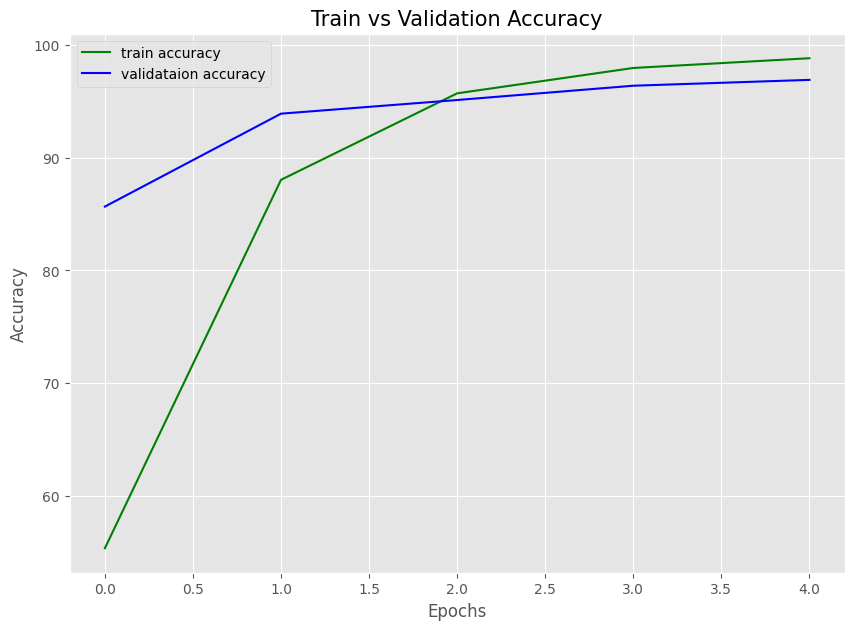

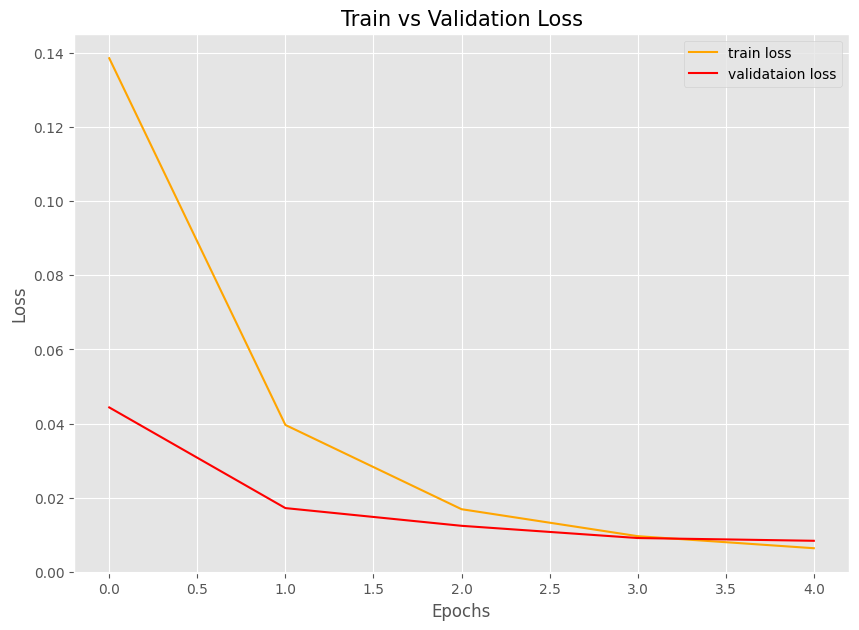

In [48]:
# accuracy plots
plt.figure(figsize=(10, 7))
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.plot(val_accuracy, color='blue', label='validataion accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Train vs Validation Accuracy",fontsize=15)
plt.legend()
plt.savefig('accuracy.png')
plt.show()

# loss plots
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.xlabel('Epochs')
plt.title("Train vs Validation Loss",fontsize=15)
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss.png')
plt.show()

In [31]:
# print("train_accuracy", train_accuracy)
# print('train_loss',train_loss)
# print('val_accuracy',val_accuracy)
# print('val_loss',val_loss)
# print("batch size",16)
# print("epoch",epochs)
# print("learnign rate",1e-4)
# print("optimizer","adam")

# import joblib
# joblib.dump(train_accuracy, 'train_accuracy.pkl')
# joblib.dump(train_loss, 'train_loss.pkl')
# joblib.dump(val_accuracy, 'val_accuracy.pkl')
# joblib.dump(val_loss, 'val_loss.pkl')

train_accuracy [67.9731027857829, 95.42747358309317, 98.6359269932757, 99.05859750240154, 99.11623439000961]
train_loss [0.10178054747789898, 0.01916044969594788, 0.007349576540720737, 0.004059072654501076, 0.003637388816208907]
val_accuracy [91.12903225806451, 94.47004608294931, 94.12442396313364, 94.98847926267281, 94.5852534562212]
val_loss [0.0256937191658546, 0.014130488249971124, 0.015228944083955783, 0.012118467278102594, 0.01437430124362922]
batch size 16
epoch 5
learnign rate 0.0001
optimizer adam


['val_loss.pkl']

In [28]:
print(f"Training on {len(train_data)} examples, validating on {len(val_data)} examples")

#validation function
def validate(model, dataloader):
    print('Validating')
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(val_data)/dataloader.batch_size)):
            data, target = data[0].to(device), data[1].to(device)
            outputs = model(data)
            loss = criterion(outputs, torch.max(target, 1)[1])
            
            val_running_loss += loss.item()
            _, preds = torch.max(outputs.data, 1)
            val_running_correct += (preds == torch.max(target, 1)[1]).sum().item()
        
        val_loss = val_running_loss/len(dataloader.dataset)
        val_accuracy = 100. * val_running_correct/len(dataloader.dataset)
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}')
        
        return val_loss, val_accuracy

# training function
def fit(model, dataloader):
    print('Training')
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    for i, data in tqdm(enumerate(dataloader), total=int(len(train_data)/dataloader.batch_size)):
        data, target = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(data)
        # print(outputs)
        # print(torch.max(target, 1)[1])
        loss = criterion(outputs, torch.max(target, 1)[1])
        train_running_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == torch.max(target, 1)[1]).sum().item()
        loss.backward()
        optimizer.step()
        
    train_loss = train_running_loss/len(dataloader.dataset)
    train_accuracy = 100. * train_running_correct/len(dataloader.dataset)
    
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}")
    
    return train_loss, train_accuracy

epochs=15
lr= 1e-3
optimizer = optim.SGD(model.parameters(), lr=lr,momentum=0.9,weight_decay=1e-3)

train_loss , train_accuracy = [], []
val_loss , val_accuracy = [], []
start = time.time()

for epoch in range(epochs):
    model = ResNet34(pretrained=True).to(device)
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_accuracy = fit(model, trainloader)
    val_epoch_loss, val_epoch_accuracy = validate(model, valloader)
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
end = time.time()

print((end-start)/60, 'minutes')

In [54]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        inputs, target = data[0].to(device, non_blocking=True), data[1].to(device, non_blocking=True)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += (predicted == torch.max(target, 1)[1]).sum().item()

print('Accuracy of the network on test images: %0.3f %%' % (
    100 * correct / total))

Accuracy of the network on test images: 95.565 %
